# Réunir des jeux de données

L’OFSP actualise quotidiennement plusieurs tableaux de données sur le covid, listés [dans cette page](https://www.bag.admin.ch/bag/fr/home/krankheiten/ausbrueche-epidemien-pandemien/aktuelle-ausbrueche-epidemien/novel-cov/situation-schweiz-und-international.html).

Dans ce notebook, on va réunir deux de ces jeux de données.

In [22]:
import pandas as pd

# matplotlib permet de générer des graphiques
import matplotlib.pyplot as plt

# on affiche les graphiques dans le notebook directement
%matplotlib inline

# police de caractères pour les graphiques
plt.rcParams['font.family'] = "Gill Sans MT"

# cette ligne permettra d’éditer le texte du PDF exporté dans Adobe Illustrator
plt.rcParams['pdf.fonttype'] = 42

# on choisit un style de graphique.
# Liste des principaux styles: https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
plt.style.use('seaborn-poster')

In [23]:
# On charge un fichier détaillé de l’OFSP dans sa version du 3 septembre 2020

df = pd.read_csv('data/Dashboards_1&2_COVID19_swiss_data_pv-2.csv')

# En principe, on pouvait aussi charger la dernière version directement sur le site de l’OFSP.
# Ça ne marche plus (mais vous pouvez essayer, on sait jamais).
# df = pd.read_excel('https://www.bag.admin.ch/dam/bag/fr/dokumente/mt/k-und-i/aktuelle-ausbrueche-pandemien/2019-nCoV/covid-19-basisdaten-fallzahlen.xlsx.download.xlsx/Dashboards_1&2_COVID19_swiss_data_pv.xlsx')

/Users/paul/.virtualenvs/dj/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Pandas a dû vous donner une erreur selon laquelle «des colonnes ont des types mixtes». Ça veut dire qu’il n’a pas pu identifier clairement quelle colonne contient une date, un entier, des float, etc. On va examiner ça.

In [24]:
# Combien de lignes en tout?
len(df)

304255

In [25]:
df.head()

,replikation_dt,fall_dt,ktn,akl,sex,Geschlecht,Sexe,fallklasse_3,pttoddat,pttod_1
0,2020-09-03 07:29:56,2020-02-24,TI,70 - 79,1,Männlich,homme,1,NaN,0
1,2020-09-03 07:29:56,2020-02-25,AG,20 - 29,1,Männlich,homme,1,NaN,0
2,2020-09-03 07:29:56,2020-02-26,BL,20 - 29,1,Männlich,homme,1,NaN,0
3,2020-09-03 07:29:56,2020-02-26,BS,20 - 29,2,Weiblich,femme,1,NaN,0
4,2020-09-03 07:29:56,2020-02-26,GE,20 - 29,1,Männlich,homme,1,NaN,0


La colonne **replikation_dt** contient la date de mise à jour du fichier. On n’en a pas besoin. Même chose pour la colonne **Geschlecht**, qui est à double.

In [26]:
del df['replikation_dt']
del df['Geschlecht']

Les autres colonnes sont expliquées dans un fichier de l’OFSP, on va leur donner un nom compréhensible…

In [27]:
df.columns = ['date cas', 'canton', 'age', 'genre_num', 'genre', 'nouveaux cas',
       'date décès', 'nouveaux décès']

C’est mieux!

Si on veut être sûr que les colonnes correspondent – par exemple pour un programme entièrement automatisé – on peut aussi utiliser la méthode suivante:

In [28]:
df.rename(columns={
    'fall_dt': 'date cas',
    'ktn': 'canton'}, inplace=True)

In [29]:
df.head()

,date cas,canton,age,genre_num,genre,nouveaux cas,date décès,nouveaux décès
0,2020-02-24,TI,70 - 79,1,homme,1,NaN,0
1,2020-02-25,AG,20 - 29,1,homme,1,NaN,0
2,2020-02-26,BL,20 - 29,1,homme,1,NaN,0
3,2020-02-26,BS,20 - 29,2,femme,1,NaN,0
4,2020-02-26,GE,20 - 29,1,homme,1,NaN,0


In [30]:
df.tail()

,date cas,canton,age,genre_num,genre,nouveaux cas,date décès,nouveaux décès
304250,NaN,ZH,80+,2,femme,0,2020-09-03,0
304251,NaN,ZH,80+,9,manquant,0,2020-09-03,0
304252,NaN,ZH,Unbekannt,1,homme,0,2020-09-03,0
304253,NaN,ZH,Unbekannt,2,femme,0,2020-09-03,0
304254,NaN,ZH,Unbekannt,9,manquant,0,2020-09-03,0


Combien de lignes avec 0 nouveau cas? Et avec 0 nouveau décès?

In [31]:
len(df[ df['nouveaux cas'] == 0 ])

287564

In [32]:
len(df[ df['nouveaux décès'] == 0 ])

303082

On comprend que notre fichier contient en fait deux tableaux, mis à la suite:
* cas confirmés par classe d’âge, genre et canton
* décès par classe d’âge, genre et canton

Dans cet exercice, on s’intéressera uniquement aux cas. L’instruction `.copy()` fait comprendre à Pandas que je ne veux pas enregistrer un sous-ensemble (une «slice») d’un tableau, mais créer un nouveau tableau.

In [33]:
df = df[ df['nouveaux cas'] > 0 ].copy()

On n’a plus besoin des colonnes relatives aux décès.

In [34]:
del df['date décès']
del df['nouveaux décès']

## Une date comme index
On indique à Python de construire l’index à partir de la colonne **date cas**:

In [35]:
df.index = pd.to_datetime( df['date cas'] )

## Filtrer les données

Pour commencer, on va s’intéresser aux cantons romands en créant un sous-ensemble avec la méthode `isin()`. Elle est très pratique pour proposer une liste de valeurs à vérifier.

On travaillera dans la suite du notebook avec la variable **dfr** (df des cantons romands).

In [36]:
cantons_romands = ['VD', 'GE', 'JU', 'VS', 'NE', 'FR']
dfr = df[ df['canton'].isin( cantons_romands ) ]

In [37]:
dfr.head()

,date cas,canton,age,genre_num,genre,nouveaux cas
date cas,,,,,,
2020-02-26,2020-02-26,GE,20 - 29,1,homme,1
2020-02-26,2020-02-26,JU,50 - 59,1,homme,1
2020-02-26,2020-02-26,VD,40 - 49,1,homme,1
2020-02-27,2020-02-27,GE,20 - 29,2,femme,1
2020-02-27,2020-02-27,GE,30 - 39,1,homme,1


## Regrouper les données
Et si on s’intéressait uniquement aux cantons, et pas aux genres et aux âges?

Pandas permet de **regrouper** des données avec la méthode `groupby()`.

Voici par exemple le total pour les cantons romands:

In [38]:
dfr.groupby('canton')['nouveaux cas'].sum()

canton
FR    1771
GE    7178
JU     280
NE     847
VD    7520
VS    2334
Name: nouveaux cas, dtype: int64

Et leurs totaux pour le mois d’avril:

In [39]:
dfr['2020-04'].groupby('canton')['nouveaux cas'].sum()

<ipython-input-39-e545a2b7dd9c>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  dfr['2020-04'].groupby('canton')['nouveaux cas'].sum()


canton
FR     543
GE    2269
JU      53
NE     276
VD    1548
VS     665
Name: nouveaux cas, dtype: int64

Mais on peut aussi regrouper par canton **et âge**:

In [40]:
dfr.groupby(['canton', 'age'])['nouveaux cas'].sum()

canton  age      
FR      0 - 9           5
        10 - 19       107
        20 - 29       389
        30 - 39       210
        40 - 49       251
        50 - 59       242
        60 - 69       149
        70 - 79       153
        80+           264
        Unbekannt       1
GE      0 - 9          87
        10 - 19       318
        20 - 29      1250
        30 - 39      1269
        40 - 49      1299
        50 - 59      1278
        60 - 69       603
        70 - 79       399
        80+           671
        Unbekannt       4
JU      0 - 9           2
        10 - 19        12
        20 - 29        39
        30 - 39        34
        40 - 49        37
        50 - 59        63
        60 - 69        42
        70 - 79        22
        80+            28
        Unbekannt       1
NE      0 - 9           6
        10 - 19        33
        20 - 29       114
        30 - 39       103
        40 - 49       141
        50 - 59       140
        60 - 69        74
        70 - 79     

## Créer un «multi-index»
Une autre manière de regrouper les données consiste à demander un nouvel index à Pandas, par exemple:
* une colonne d’index pour le canton
* une colonne d’index pour la date

Voici ce que ça donne:

In [41]:
dfc = dfr.set_index(['canton', 'date cas'])
dfc.head()

age  genre_num  genre  nouveaux cas
canton date cas                                           
GE     2020-02-26  20 - 29          1  homme             1
JU     2020-02-26  50 - 59          1  homme             1
VD     2020-02-26  40 - 49          1  homme             1
GE     2020-02-27  20 - 29          2  femme             1
       2020-02-27  30 - 39          1  homme             1

## Exercice
Trouvez:
* le nombre total de cas par canton en juin
* le nombre total de cas à Fribourg en juillet

# Réunir deux jeux de données
On peut ajouter les noms des cantons à l’aide d’un autre tableau de données, qu’on va charger dans la variable **df_cantons**:

In [20]:
df_cantons = pd.read_csv('data/cantons_geo.csv')
df_cantons.head()

,Unnamed: 0,name_fr,name_de,abbrev,lat,lng
0,0,Argovie,Aargau,AG,"47,3876664","8,1554295"
1,1,Appenzell Rhodes-Extérieures,Appenzell Ausserrhoden,AR,"47,366481","9,3000916"
2,2,Appenzell Rhodes-Intérieures,Appenzell Innerrhoden,AI,"47,3161925","9,6316573"
3,3,Bâle-Campagne,Basel-Landschaft,BL,"47,4418122","7,7644002"
4,4,Bâle-Ville,Basel-Stadt,BS,"47,5619253","7,592768"


Accessoirement, ce tableau vous donne les coordonnées géographiques des centres des cantons. Mais on ne va utiliser que leur abréviation (AG) et leur nom en français.

In [21]:
df_cantons = df_cantons[['name_fr', 'abbrev']]

Et maintenant, on est prêt à **réunir ces tableaux**! Il faut indiquer à Pandas quelle colonne il doit utiliser pour aligner chaque ligne, et comment gérer les lignes pour lesquelles il n’existe aucune correspondance.

In [22]:
dfm = df.merge(df_cantons, left_on='canton', right_on='abbrev')
dfm.head()

,date cas,canton,age,genre_num,genre,nouveaux cas,name_fr,abbrev
0,2020-02-24,TI,70 - 79,1,homme,1,Tessin,TI
1,2020-02-27,TI,50 - 59,2,femme,1,Tessin,TI
2,2020-02-27,TI,70 - 79,1,homme,2,Tessin,TI
3,2020-02-29,TI,50 - 59,2,femme,1,Tessin,TI
4,2020-03-01,TI,80+,1,homme,1,Tessin,TI


Ici, on a gardé toutes les lignes de **dfr**, mais seulement les lignes de **df_cantons** qui y correspondent. C’est ce qu’on appelle un «left join»: le résultat contient tout le tableau de gauche mais seulement les éléments pertinents du tableau de droite. Cette page [détaille les différents types de «joints»](https://www.datacourses.com/concatenate-merge-and-join-data-with-pandas-598/) qu’on peut utiliser.

On va maintenant faire la même opération sur **df** (Suisse entière), et écraser **df** avec le résultat.

In [48]:
df = df.merge(df_cantons, left_on='canton', right_on='abbrev')
df.head()

In [50]:
# On n’a pas besoin de l’abréviation à double
del df['abbrev']

## Remplacer des valeurs

On a vu passer cette drôle de classe d’âge: «Unbekannt»… Comment mettre ça en français?

In [51]:
df['age'].value_counts()

20 - 29    2777
50 - 59    2574
30 - 39    2514
40 - 49    2386
60 - 69    1895
80+        1377
70 - 79    1354
10 - 19    1325
0 - 9       347
Inconnu      43
Name: age, dtype: int64

In [52]:
df['age'].replace('Unbekannt', 'Inconnu')

0        70 - 79
1        50 - 59
2        70 - 79
3        50 - 59
4            80+
          ...   
16587    10 - 19
16588    20 - 29
16589    50 - 59
16590    20 - 29
16591    20 - 29
Name: age, Length: 16592, dtype: object

Mais pourquoi est-ce qu’on a encore des «Unbekannt»?

In [53]:
df[df['age'] == 'Unbekannt'].head()

,date cas,canton,age,genre_num,genre,nouveaux cas,name_fr


**Pour effectuer un remplacement, il faut:**
* ajouter `inplace=True` -> `.replace('expression à trouver', 'remplacement', inplace=True)`
* soit sauvegarder le résultat dans la variable df

In [54]:
df.replace('Unbekannt', 'Inconnu', inplace=True)
# ou: df = df.replace('Unbekannt', 'Inconnu')

Cette fois, on est bon!

In [55]:
df[df['age'] == 'Unbekannt']

,date cas,canton,age,genre_num,genre,nouveaux cas,name_fr


## Rechercher du texte

Avec `str.contains`, on peut chercher du texte:

In [56]:
df[df['age'].str.contains('20')]

,date cas,canton,age,genre_num,genre,nouveaux cas,name_fr
5,2020-03-02,TI,20 - 29,1,homme,1,Tessin
10,2020-03-03,TI,20 - 29,1,homme,1,Tessin
19,2020-03-04,TI,20 - 29,1,homme,1,Tessin
39,2020-03-07,TI,20 - 29,2,femme,1,Tessin
51,2020-03-09,TI,20 - 29,2,femme,2,Tessin
...,...,...,...,...,...,...,...
16575,2020-08-12,UR,20 - 29,1,homme,1,Uri
16576,2020-08-13,UR,20 - 29,2,femme,1,Uri
16588,2020-08-24,UR,20 - 29,1,homme,1,Uri
16590,2020-08-25,UR,20 - 29,1,homme,1,Uri


Mais aussi avec des **expressions régulières** comme \d{2}, qui signifie «2 chiffres». Voici pour rappel:

* [une cheat sheet en anglais sur les Regular Expressions](https://cheatography.com/davechild/cheat-sheets/regular-expressions/)
* [une cheat sheet en français](https://fr.wikibooks.org/wiki/Programmation_Bash/Regex)
* et le site **[regexr.com](https://regexr.com/)** pour tester ses expressions

L’expression suivante prendra toutes les tranches d’âges. On aurait aussi pu montrer toutes les lignes qui ne contiennent pas «Inconnu».

In [57]:
df[df['age'].str.contains('\d{2}')]

,date cas,canton,age,genre_num,genre,nouveaux cas,name_fr
0,2020-02-24,TI,70 - 79,1,homme,1,Tessin
1,2020-02-27,TI,50 - 59,2,femme,1,Tessin
2,2020-02-27,TI,70 - 79,1,homme,2,Tessin
3,2020-02-29,TI,50 - 59,2,femme,1,Tessin
4,2020-03-01,TI,80+,1,homme,1,Tessin
...,...,...,...,...,...,...,...
16587,2020-08-24,UR,10 - 19,1,homme,1,Uri
16588,2020-08-24,UR,20 - 29,1,homme,1,Uri
16589,2020-08-24,UR,50 - 59,1,homme,1,Uri
16590,2020-08-25,UR,20 - 29,1,homme,1,Uri


# Créer des graphiques

Revenons à nos cantons romands… Pour commencer, on va reporter ce qu’on a fait dans le df principal en recréant **dfr** à partir de **df**:

In [59]:
cantons_romands = ['VD', 'GE', 'JU', 'VS', 'NE', 'FR']
dfr = df[ df['canton'].isin( cantons_romands ) ]

Essayons de montrer le total des cas romands par âge et sexe, dans un graphique en barres…

Pour ce faire:

* on groupe par âge et genre: `dfr.groupby(['age', 'genre']).sum()`
* on précise que le genre de graphique est `bar`

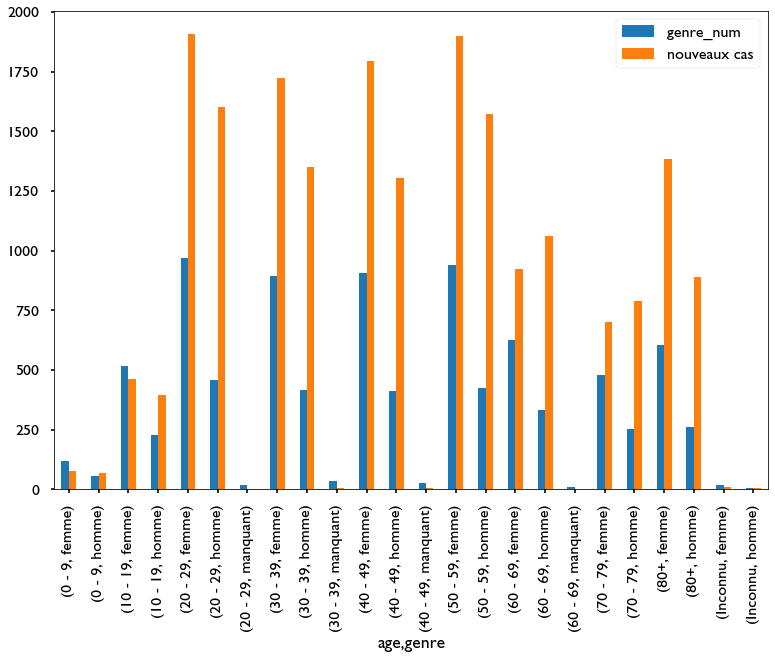

In [71]:
dfr.groupby(['age', 'genre']).sum().plot(kind='bar')

Oups: des genres «manquants», des âges «inconnus»… On va les retirer. Mais d’abord, on compte le nombre de lignes que ça représente pour pouvoir l’indiquer dans une note.

In [72]:
unknown_age = dfr['age'] == 'Inconnu'
unknown_gender = dfr['age'] == 'manquant'

La barre verticale | correspond à un opérateur OR:

In [73]:
len(dfr[ unknown_age | unknown_gender ])

16

Refaisons notre graphique. Et cette fois, on l’exporte!

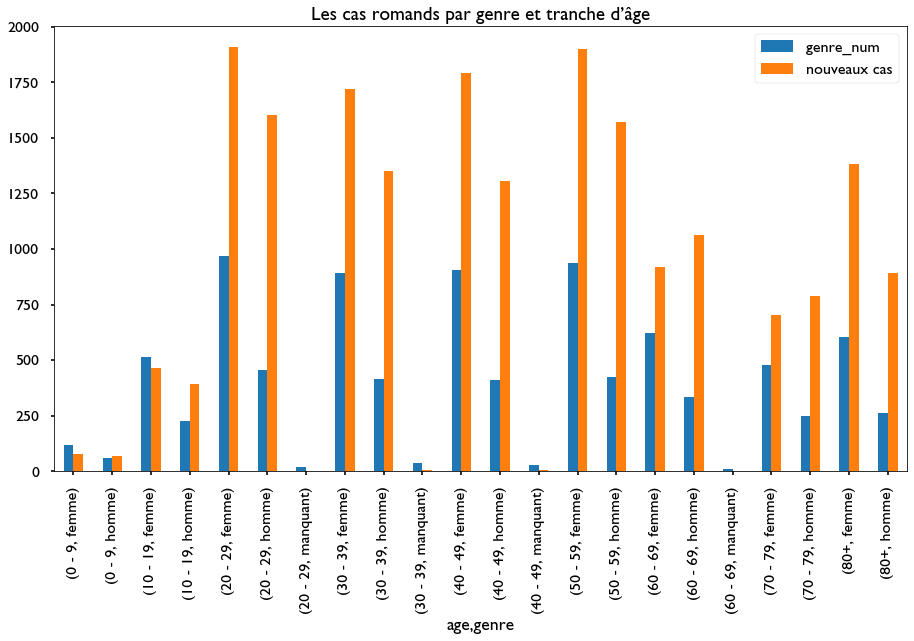

In [76]:
dfr[ -unknown_age & -unknown_gender ].groupby(['age', 'genre']).sum().plot(kind='bar')

# Ajuster les marges pour que le PDF exporté ne soit pas rogné
plt.tight_layout()

plt.title('Les cas romands par genre et tranche d’âge')

plt.savefig('cas-romands-age-genre.pdf')

# Exercices bonus

* Arrivez-vous à réunir notre df actuel avec la population des cantons romands, contenue dans **data/cantons_population.csv** ?

* Pouvez-vous utiliser une moyenne mobile sur 5 ou 7 jours, comme nous l’avons fait dans le fichier Covid-data.ipynb?